## Autoencoders and Variational Autoencoders

In [58]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from pathlib import Path
import os

import numpy as np

import matplotlib.pyplot as plt

### MINIST dataset

In [2]:
PATH = Path("/data2/yinterian/data")

In [3]:
trans = transforms.Compose([transforms.ToTensor()])
train_ds = MNIST(PATH, train=True, transform=trans, download=True)
val_ds = MNIST(PATH, train=False, transform=trans, download=True)

In [4]:
x, y = train_ds[0]

In [5]:
x.shape

torch.Size([1, 28, 28])

In [6]:
y

tensor(5)

In [7]:
batch_size = 256
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

### Autoencoder model 

In [148]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [149]:
learning_rate = 1e-3
model = autoencoder().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=1e-5)

In [150]:
criterion = nn.MSELoss()
def val_loss(model, val_dl):
    model.eval()
    total_loss = 0.0
    total = 0
    for x, _ in train_dl:
        x = x.cuda()
        output = model(x)
        loss = criterion(output, x)
        total += x.size(0)
        total_loss += x.size(0)*loss.item()
    return total_loss/total     

In [151]:
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for x, _ in train_dl:
        x = x.cuda()
        output = model(x)
        loss = criterion(output, x)
                       
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                       
    if epoch % 10 == 0:
        valid_loss = val_loss(model, val_dl)
        print('epoch [{}/{}], loss:{:.4f} val_loss:{:.4f}'.format(epoch+1, num_epochs, loss.item(), valid_loss))

torch.save(model.state_dict(), PATH/"conv_autoencoder.pth")

epoch [1/50], loss:0.0430 val_loss:0.0394
epoch [11/50], loss:0.0283 val_loss:0.0280
epoch [21/50], loss:0.0278 val_loss:0.0263
epoch [31/50], loss:0.0242 val_loss:0.0257
epoch [41/50], loss:0.0271 val_loss:0.0254


## Results on new data

In [157]:
def print_results(imgs):
    fig=plt.figure(figsize=(8, 4))
    columns = 4
    rows = 2
    for i in range(0, columns*rows):
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(imgs[i][0], cmap='gray')
    plt.show()

In [152]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [12]:
model = autoencoder().cuda()
load_model(model, PATH/"conv_autoencoder.pth")

In [153]:
val_dl = DataLoader(val_ds, batch_size=8, shuffle=False)

In [154]:
x, y = next(iter(val_dl))

In [155]:
x.shape

torch.Size([8, 1, 28, 28])

In [156]:
def to_image(x):
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

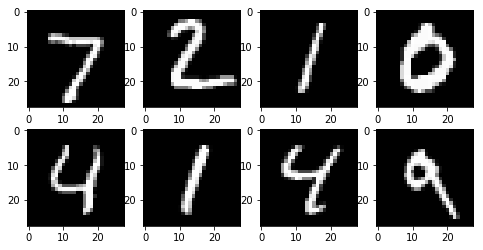

In [158]:
print_results(x)

In [159]:
x_hat = model(x.cuda())

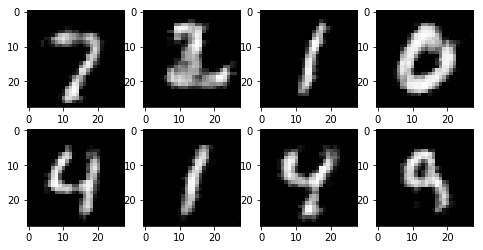

In [160]:
img_hat = to_image(x_hat.cpu().detach())
print_results(img_hat)

## Variational Autoencoder

### Model

In [21]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [22]:
class UnFlatten(nn.Module):
    def forward(self, input, size=128):
        return input.view(input.size(0), size, 1, 1)

In [23]:
class VAE(nn.Module):
    def __init__(self, h_dim=128, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).cuda()
        z = mu + std * esp
        return z

    def encode(self, x):
        h = self.encoder(x)
        # bottleneck
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [24]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [25]:
model = VAE().cuda()

In [26]:
x, y = next(iter(train_dl))

In [27]:
x.shape

torch.Size([64, 1, 28, 28])

In [28]:
x_hat, _, _ = model(x.cuda())
x_hat.shape

torch.Size([64, 1, 28, 28])

### Loss
Reconstruction + KL divergence losses summed over all elements and batch <br>
see Appendix B from VAE paper (page 11): <br>
Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014 <br>
https://arxiv.org/abs/1312.6114 <br>
-0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2) <br>

https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians

https://www.reddit.com/r/MachineLearning/comments/4ujr2s/what_loss_to_use_for_variational_auto_encoder/

In [125]:
def loss_fn(recon_x, x , mu, logvar):
    #bce = F.mse_loss(recon_x, x, size_average=False)
    bce = F.binary_cross_entropy(recon_x.view(-1), x.view(-1), size_average=False)
    kld = -0.5 * torch.sum(1 + 2*logvar - mu.pow(2) - logvar.exp().pow(2))
    return bce + 3 * kld, bce, kld

### Training

In [119]:
def train_vae(model, optimizer, epochs=10):
    for epoch in range(epochs):
        total_loss = 0.0
        total_bce = 0.0
        total_kld = 0.0
        total = 0
        for x, _ in train_dl:
            x = x.cuda()
            x_hat, mu, logvar = model(x)
            loss, bce, kld = loss_fn(x_hat, x , mu, logvar)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_bce += bce.item()
            total_kld += kld.item()
            total += x.size(0)

        to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(
            epoch+1, epochs, total_loss/total, total_bce/total, total_kld/total)
        if epoch % 10 == 0:
            print(to_print)

In [120]:
model = VAE().cuda()

In [121]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [122]:
train_vae(model, optimizer, epochs=50)

Epoch[1/50] Loss: 195.915 183.495 4.140
Epoch[11/50] Loss: 155.774 121.186 11.529
Epoch[21/50] Loss: 154.370 118.645 11.909
Epoch[31/50] Loss: 153.708 117.408 12.100
Epoch[41/50] Loss: 153.357 116.747 12.203


In [123]:
train_vae(model, optimizer, epochs=50)

Epoch[1/50] Loss: 153.028 116.211 12.272
Epoch[11/50] Loss: 152.898 115.858 12.346
Epoch[21/50] Loss: 152.662 115.480 12.394
Epoch[31/50] Loss: 152.691 115.324 12.456
Epoch[41/50] Loss: 152.473 115.113 12.453


In [124]:
train_vae(model, optimizer, epochs=50)

Epoch[1/50] Loss: 152.399 114.888 12.504
Epoch[11/50] Loss: 152.438 114.812 12.542
Epoch[21/50] Loss: 152.464 114.740 12.575
Epoch[31/50] Loss: 152.131 114.414 12.572
Epoch[41/50] Loss: 152.094 114.345 12.583


In [48]:
save_model(model, PATH/"conv_vae.pth")

### Looking at Results

In [127]:
val_dl = DataLoader(val_ds, batch_size=8, shuffle=False)

In [128]:
x, y = next(iter(val_dl))

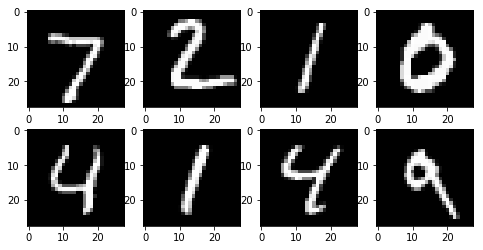

In [129]:
print_results(x)

In [115]:
load_model(model, PATH/"conv_vae.pth")

In [130]:
x_hat, _, _ = model(x.cuda())

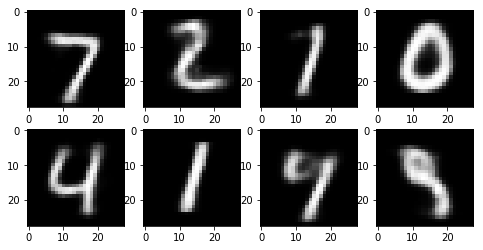

In [131]:
img_hat = to_image(x_hat.cpu().detach())
print_results(img_hat)

## Generating Syntetic Numbers

In [143]:
z_dim = 32
n = 8
s = np.random.normal(0, 1, z_dim*n)

In [144]:
s = s.reshape(n,-1)
s.shape

(8, 32)

In [145]:
z = torch.Tensor(s)

In [146]:
x_hat = model.decode(z.cuda())
img_hat = to_image(x_hat.cpu().detach())

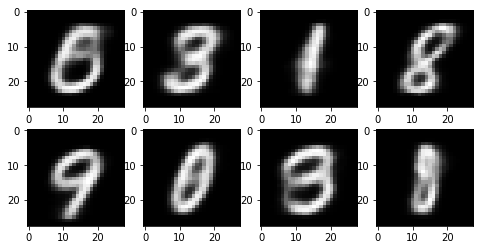

In [147]:
print_results(img_hat)

## References
* https://github.com/L1aoXingyu/pytorch-beginner/tree/master/08-AutoEncoder
* https://github.com/sksq96/pytorch-vae/blob/master/vae-cnn.ipynb